# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


## Generating Faces with Google CoLab

This notebook demonstrates how to run [NVidia StyleGAN2 ADA](https://github.com/NVlabs/stylegan2-ada) inside a Google CoLab notebook for the purpose of generating human faces. The notebook allows you to record a video in which people's faces smoothly change from frame to frame. This is done by a smooth transition from some initial vector to some final one in the hidden space of face embeddings. GPU is assumed.

First, we clone StyleGAN3 from GitHub.

In [2]:
# HIDE OUTPUT
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 207, done.
remote: Total 207 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (207/207), 4.17 MiB | 2.22 MiB/s, done.
Resolving deltas: 100% (98/98), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 36.3 MB/s 



Verify that StyleGAN has been cloned.

In [ ]:
!ls /content/stylegan3

avg_spectra.py	 Dockerfile	  gen_video.py	metrics      train.py
calc_metrics.py  docs		  gui_utils	README.md    visualizer.py
dataset_tool.py  environment.yml  legacy.py	torch_utils  viz
dnnlib		 gen_images.py	  LICENSE.txt	training


## Run StyleGan From Command Line

Add the StyleGAN folder to Python so that you can import it. I based this code below on code from NVidia for the original StyleGAN paper. When you use StyleGAN you will generally create a GAN from a seed number. This seed is an integer, such as 6600, that will generate a unique image. The seed generates a latent vector containing 512 floating-point values. The GAN code uses the seed to generate these 512 values. The seed value is easier to represent in code than a 512 value vector; however, while a small change to the latent vector results in a slight change to the image, even a small change to the integer seed value will produce a radically different image.

In [3]:
# HIDE OUTPUT
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/"\
      "stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

!python /content/stylegan3/gen_images.py \
    --network={URL} \
  --outdir=/content/results --seeds=6600-6625 

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
Generating image for seed 6600 (0/26) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Generating image for seed 6601 (1/26) ...
Generating image for seed 6602 (2/26) ...
Generating image for seed 6603 (3/26) ...
Generating image for seed 6604 (4/26) ...
Generating image for seed 6605 (5/26) ...
Generating image for seed 6606 (6/26) ...
Generating image for seed 6607 (7/26) ...
Generating image for seed 6608 (8/26) ...
Generating image for seed 6609 (9/26) ...
Generating image for seed 6610 (10/26) ...
Generating image for seed 6611 (11/26) ...
Generating image for seed 6612 (12/26) ...
Generating image for seed 6613 (13/26) ...
Generating image for seed 6614 (14/26) ...
Generating image for seed 6615 (15/26) ...
Generating image for seed 6616 (16/26) ...
Generating image for seed 661

We can now display the images created.

In [4]:
!ls /content/results

seed6600.png  seed6606.png  seed6612.png  seed6618.png	seed6624.png
seed6601.png  seed6607.png  seed6613.png  seed6619.png	seed6625.png
seed6602.png  seed6608.png  seed6614.png  seed6620.png
seed6603.png  seed6609.png  seed6615.png  seed6621.png
seed6604.png  seed6610.png  seed6616.png  seed6622.png
seed6605.png  seed6611.png  seed6617.png  seed6623.png


Next, copy the images to a folder of your choice on GDrive.

In [ ]:
!cp /content/results/* \
    /content/drive/My\ Drive/projects/stylegan3

## Run StyleGAN From Python Code

Add the StyleGAN folder to Python so that you can import it.  

In [6]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, 
         nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs) 
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail("Must specify class label with --class when using "\
            "a conditional network")
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ("warn: --class=lbl ignored when running on "\
            "an unconditional network")
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', 
                   class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(\
      torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [7]:
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/"\
  "versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...


We can now generate images from integer seed codes in Python.

Seed 1


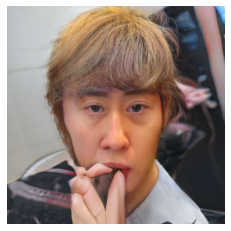

Seed 2


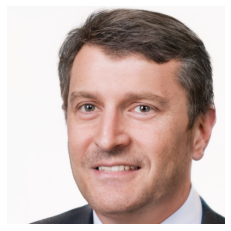

Seed 3


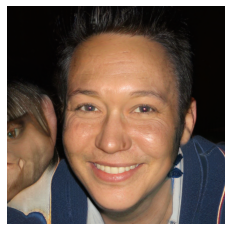

In [9]:
# Choose your own starting and ending seed.
SEED_FROM = 1
SEED_TO = 4

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

## Examining the Latent Vector

Figure shows the effects of transforming the latent vector between two images. We accomplish this transformation by slowly moving one 512-value latent vector to another 512 vector. A high-dimension point between two latent vectors will appear similar to both of the two endpoint latent vectors. Images that have similar latent vectors will appear similar to each other.

**Figure: Transforming the Latent Vector**
![GAN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_progression.jpg "GAN")

In [10]:
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/"\
  "versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

vector_size = G.z_dim
# range(8192,8300)
seeds = expand_seed( [8192+1,8192+9], vector_size)
#generate_images(Gs, seeds,truncation_psi=0.5)
print(seeds[0].shape)

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
(1, 512)


The following code will move between the provided seeds.  The constant STEPS specify how many frames there should be between each seed.

In [11]:
# HIDE OUTPUT
# Choose your seeds to morph through and the number of steps to 
# take to get to each.

SEEDS = [6624,6618,6616] # Better 
STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y faces_movie.mp4

Seed 6624:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 6618:   0%|          | 0/100 [00:00<?, ?it/s]

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

You can now download the generated video.

In [12]:
from google.colab import files
files.download('faces_movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>